<a href="https://colab.research.google.com/github/duong233/EnglishLanguageLearningPrediction/blob/main/ELLsUsingTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/MachineLearning/EnglishLanguageLearner

/content/drive/MyDrive/MachineLearning/EnglishLanguageLearner


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv('Data/train.csv')
data['full_text'][0]

"I think that students would benefit from learning at home,because they wont have to change and get up early in the morning to shower and do there hair. taking only classes helps them because at there house they'll be pay more attention. they will be comfortable at home.\n\nThe hardest part of school is getting ready. you wake up go brush your teeth and go to your closet and look at your cloths. after you think you picked a outfit u go look in the mirror and youll either not like it or you look and see a stain. Then you'll have to change. with the online classes you can wear anything and stay home and you wont need to stress about what to wear.\n\nmost students usually take showers before school. they either take it before they sleep or when they wake up. some students do both to smell good. that causes them do miss the bus and effects on there lesson time cause they come late to school. when u have online classes u wont need to miss lessons cause you can get everything set up and go t

In [ ]:
data.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3911 entries, 0 to 3910
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   text_id      3911 non-null   object 
 1   full_text    3911 non-null   object 
 2   cohesion     3911 non-null   float64
 3   syntax       3911 non-null   float64
 4   vocabulary   3911 non-null   float64
 5   phraseology  3911 non-null   float64
 6   grammar      3911 non-null   float64
 7   conventions  3911 non-null   float64
dtypes: float64(6), object(2)
memory usage: 244.6+ KB


#Import necessary libraries

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 51.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 74.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 21.9 MB/s eta 0:00:00


In [ ]:
import torch.nn as nn
import torch
from tqdm.notebook import tqdm
import gc

In [ ]:
import transformers
from transformers import AutoModel
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split

In [ ]:
print('transformers version: ', transformers.__version__)

transformers version:  4.28.1


In [ ]:
config = {
    'model': 'bert-base-uncased',
    'dropout':0,
    'max_length': 512,
    'batch_size': 16,
    'epochs': 4,
    'freeze_lr': 4e-4,
    'unfreeze_lr': 2e-5,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'scheduler': 'CosineAnnealingWarmRestarts'
}

#Tokenizer, Dataset, DataLoader

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(config['model'])

In [ ]:
df = data
test_df = pd.read_csv('Data/test.csv')

In [ ]:
print(df.columns.to_list())

['text_id', 'full_text', 'cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']


In [ ]:
class EssayDataset:
  def __init__(self, df, config, tokenizer=None, is_test=False):
    self.df = df.reset_index(drop=True)
    self.classes = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']
    self.max_len = config['max_length']
    self.tokenizer = tokenizer
    self.is_test = is_test
  
  def __getitem__(self,idx):
    sample = self.df['full_text'][idx]
    tokenized = tokenizer.encode_plus(sample,
                                      None,
                                      add_special_tokens=True,
                                      max_length=self.max_len,
                                      truncation=True,
                                      padding='max_length'
                                      )
    
    inputs = {
        "input_ids": torch.tensor(tokenized['input_ids'], dtype=torch.long),
        "token_type_ids": torch.tensor(tokenized['token_type_ids'], dtype=torch.long),
        "attention_mask": torch.tensor(tokenized['attention_mask'], dtype=torch.long)
    }

    if self.is_test==True:
      return inputs
    
    label = self.df.loc[idx,self.classes].to_list()
    targets = {
        "labels":torch.tensor(label, dtype=torch.float32)
    }
    return inputs, targets
  
  def __len__(self):
    return len(self.df)

In [ ]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=32, shuffle=True)
print(train_df.shape)
print(val_df.shape)

(3128, 8)
(783, 8)


In [ ]:
train_ds = EssayDataset(train_df, config, tokenizer=tokenizer)
val_ds = EssayDataset(val_df, config, tokenizer=tokenizer)
test_ds = EssayDataset(test_df, config, tokenizer=tokenizer, is_test=True)

In [ ]:
train_ds[0][0]['input_ids'].shape

torch.Size([512])

In [ ]:
train_loader = torch.utils.data.DataLoader(train_ds,
                                           batch_size=config['batch_size'],
                                           num_workers=2,
                                           pin_memory=True)

val_loader = torch.utils.data.DataLoader(val_ds,
                                           batch_size=config['batch_size'],
                                           num_workers=2,
                                           pin_memory=True)
print('loader shapes: ',len(train_loader), len(val_loader))

loader shapes:  196 49


#Model 1: Unfreeze Encoder

The encoder returns 2 outputs, i turned off return_dict to unpack them. The first output is the last hidden state of the model, and the second output is pooled output of the model

The output we get:
* last_hidden_state
* pooled_output

We can also choose the freeze the encoder to train the fc layers



In [ ]:
class EssayModel(nn.Module):
  def __init__(self,config,num_classes=6):
    super(EssayModel,self).__init__()
    self.model_name = config['model']
    self.encoder = AutoModel.from_pretrained(self.model_name)
    self.dropout = nn.Dropout(config['dropout'])
    self.fc1 = nn.Linear(self.encoder.config.hidden_size, 64)
    self.fc2 = nn.Linear(64, num_classes)

  def forward(self,inputs):
    _, outputs = self.encoder(**inputs, return_dict=False)
    outputs = self.dropout(outputs)
    outputs = self.fc1(outputs)
    outputs = self.fc2(outputs)
    return outputs

#Model 2: Freeze Encoder
Take less GPU memory, optimizes the training, reduces overfitting

In [ ]:
class FrozenEssayModel(nn.Module):
  def __init__(self, config, num_classes=6):
    super(FrozenEssayModel, self).__init__()
    self.model_name = config['model']
    self.encoder = AutoModel.from_pretrained(self.model_name)
    for param in self.encoder.base_model.parameters():
      param.requires_grad = False
    self.dropout = nn.Dropout(config['dropout'])
    self.fc1 = nn.Linear(self.encoder)

#Trainer

In [ ]:
class Trainer:
  def __init__(self, model, loaders, config, lr='unfreeze'):
    self.model=model
    self.train_loader, self.val_loader = loaders
    self.config = config
    self.input_keys = ['input_ids', 'token_type_ids', 'attention_mask']

    self.loss = nn.SmoothL1Loss()

    if lr == 'unfreeze':
      self.lr = self.config['unfreeze_lr']
    
    self.optim = self._get_optim()

    self.scheduler_options = {
            'CosineAnnealingWarmRestarts': torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(self.optim, T_0=5,eta_min=1e-7)
    }
    self.scheduler = self.scheduler_options[self.config['scheduler']]

    self.train_losses = []
    self.val_losses = []
    self.val_mcrmse = []

  def _get_optim(self):
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in self.model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
        {'params': [p for n, p in self.model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
    optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=self.lr)
    return optimizer

  def mcrmse(self, outputs, targets):
    colwise = torch.mean(torch.square(targets-outputs), dim=0)
    loss = torch.mean(torch.sqrt(colwise), dim=0)
    return loss

  def train_one_epoch(self,epoch):
    running_loss=0
    progress = tqdm(self.train_loader, total=len(self.train_loader))

    for i, (inputs,targets) in enumerate(progress):

      self.optim.zero_grad()

      inputs = {k:inputs[k].to(device=config['device']) for k in inputs.keys()}
      targets = targets = targets['labels'].to(device=config['device'])

      outputs = self.model(inputs)

      loss = self.loss(outputs, targets)
      running_loss += loss.item()

      loss.backward()
      self.optim.step()

      if self.config['scheduler'] == 'CosineAnnealingWarmRestarts':
        self.scheduler.step(epoch-1+i/len(self.train_loader))

        del inputs, targets, outputs, loss

      train_loss = running_loss/len(self.train_loader)
      self.train_losses.append(train_loss)

  @torch.no_grad()
  def valid_one_epoch(self, epoch):

    running_loss = 0
    running_mcrmse = 0
    progress = tqdm(self.val_loader, total=len(self.val_loader))

    for (inputs, targets) in progress:

      inputs = {k:inputs[k].to(device=config['device']) for k in inputs.keys()}
      targets = targets['labels'].to(device=config['device'])

      outputs = self.model(inputs)

      loss = self.loss(outputs, targets)
      running_loss +=loss.item()

      running_mcrmse += self.mcrmse(outputs, targets).item()

      del inputs, targets, outputs, loss

    val_loss = running_loss/len(self.val_loader)
    self.val_losses.append(val_loss)

    self.val_mcrmse.append(running_mcrmse/len(self.val_loader))

    del running_mcrmse

  def test(self, test_loader):
        
    preds = []
    for (inputs) in test_loader:
        inputs = {k:inputs[k].to(device=config['device']) for k in inputs.keys()}
        
        outputs = self.model(inputs)
        preds.append(outputs.detach().cpu())
        
    preds = torch.concat(preds)
    return preds
  
  def fit(self):
    fit_progress = tqdm(
        range(1, self.config['epochs']+1),
        leave=True,
        desc='Training'
    )

    for epoch in fit_progress:

      self.model.train()
      fit_progress.set_description(f"EPOCH {epoch}/{self.config['epochs']} | training")
      self.train_one_epoch(epoch)
      self.clear()

      self.model.eval()
      fit_progress.set_description(f"EPOCH {epoch}/{self.config['epochs']} | validating")
      self.valid_one_epoch(epoch)
      self.clear()

      print(f"{'-'*30} EPOCH {epoch} / {self.config['epochs']}{'-'*30}")
      print(f"train loss: {self.train_losses[-1]}")
      print(f"valid loss: {self.val_losses[-1]}\n\n")
  
  def clear(self):
    gc.collect()
    torch.cuda.empty_cache()


#Training

In [ ]:
model = EssayModel(config).to(device=config['device'])
trainer_unfreeze = Trainer(model, (train_loader, val_loader), config, lr='unfreeze')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
trainer_unfreeze.fit()

Training:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

------------------------------ EPOCH 1 / 4------------------------------
train loss: 0.6494157209004067
valid loss: 0.16451513630395032




  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

------------------------------ EPOCH 2 / 4------------------------------
train loss: 0.12709005595165856
valid loss: 0.1272605887177039




  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

------------------------------ EPOCH 3 / 4------------------------------
train loss: 0.11053187434314465
valid loss: 0.1358607741338866




  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

------------------------------ EPOCH 4 / 4------------------------------
train loss: 0.0974769469502629
valid loss: 0.13571765000114636




#Results

In [ ]:
training_loss = [trainer_unfreeze.train_losses[195],trainer_unfreeze.train_losses[381],trainer_unfreeze.train_losses[577],trainer_unfreeze.train_losses[783]]
# valid_loss = [trainer_unfreeze.val_losses[195],trainer_unfreeze.val_losses[381],trainer_unfreeze.val_losses[577],trainer_unfreeze.val_losses[783]]
# valid_mcrmse = [trainer_unfreeze.val_mcrmse[195],trainer_unfreeze.val_mcrmse[381],trainer_unfreeze.val_mcrmse[577],trainer_unfreeze.val_mcrmse[783]]

In [ ]:
losses_df = pd.DataFrame({'epoch': list(range(1, config['epochs']+1)),
                          'train_loss': training_loss,
                          'val_loss': trainer_unfreeze.val_losses,
                          'val_mcrmse': trainer_unfreeze.val_mcrmse
                          })
losses_df

,epoch,train_loss,val_loss,val_mcrmse
0,1,0.649416,0.164515,0.570661
1,2,0.120885,0.127261,0.499751
2,3,0.105627,0.135861,0.516837
3,4,0.097477,0.135718,0.516582


#Plot

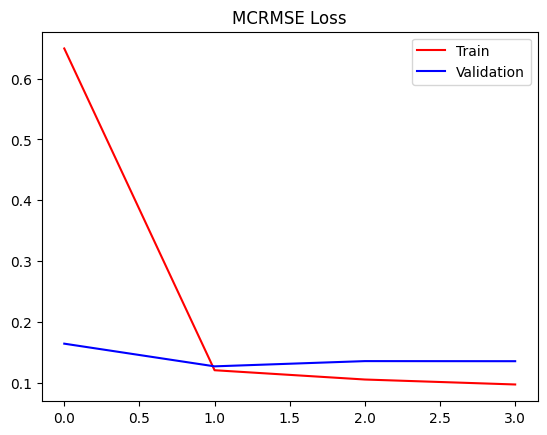

In [ ]:
plt.plot(training_loss, color='red')
plt.plot(trainer_unfreeze.val_losses, color='blue')
plt.title('MCRMSE Loss')
plt.legend(['Train', 'Validation'])
plt.show()

#Test

In [ ]:
test_loader = torch.utils.data.DataLoader(test_ds,
                                           batch_size=config['batch_size'],
                                           num_workers=2,
                                           pin_memory=True)

In [ ]:
preds = trainer_unfreeze.test( test_loader)

In [ ]:
preds[0]

tensor([3.0909, 3.0336, 3.2327, 3.1491, 3.1029, 3.0736])

In [ ]:
classes = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']

In [ ]:
test_df[classes] = preds

In [ ]:
test_df

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0000C359D63E,when a person has no experience on a job their...,3.090890,3.033574,3.232674,3.149067,3.102932,3.073588
1,000BAD50D026,Do you think students would benefit from being...,2.763927,2.619788,2.899789,2.607000,2.458147,2.633059
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde...",3.807939,3.758231,3.846883,3.786604,3.760212,3.764792
